# Лабораторная работа №2. Обработка признаков, ч.1
**Студент:** Кривцов Н.А.  
**Группа:** ИУ5-22М   


## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

## Загрузка и просмотр датасета

Датасет содержит данные о качестве питьевой воды в 3276 водоемах мира. Для анализа качества используются 9 числовых показателей, таких как pH, жесткость и концентрация различных вредных веществ.

In [2]:
data = pd.read_csv('/content/drive/MyDrive/ММО/water_potability.csv')

In [3]:
data.shape

(3276, 10)

In [4]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [5]:
data = data.iloc[:,:-1]

# 1. Заполнение пропусков
Заполним пропуски с применением `KNNImputer`

In [6]:
# Количество пропусков
missing_values = [(i, data[i].isnull().sum()) for i in data.columns if data[i].isnull().sum() != 0]
missing_values

[('ph', 491), ('Sulfate', 781), ('Trihalomethanes', 162)]

In [7]:
cols_to_impute = [i[0] for i in missing_values]
cols_to_impute

['ph', 'Sulfate', 'Trihalomethanes']

In [8]:
data_to_impute = data[cols_to_impute]
data_to_impute

,ph,Sulfate,Trihalomethanes
0,NaN,368.516441,86.990970
1,3.716080,NaN,56.329076
2,8.099124,NaN,66.420093
3,8.316766,356.886136,100.341674
4,9.092223,310.135738,31.997993
...,...,...,...
3271,4.668102,359.948574,66.687695
3272,7.808856,NaN,NaN
3273,9.419510,NaN,69.845400
3274,5.126763,NaN,77.488213


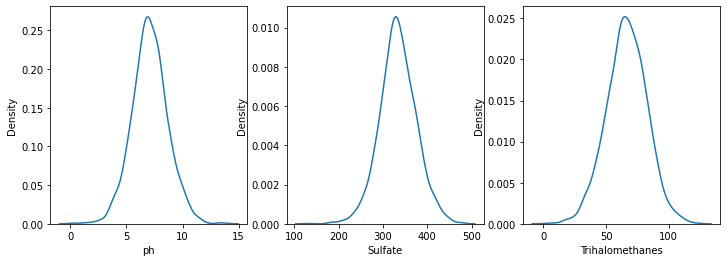

In [9]:
n_cols = 3
n_rows = 1
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 4))
for i, column in enumerate(data_to_impute):
  sns.kdeplot(data_to_impute[column], ax=axes[i%n_cols])

In [10]:
imputer = KNNImputer(n_neighbors=3)
temp_data = pd.DataFrame(imputer.fit_transform(data))
temp_data.columns = data.columns
imputed_data = temp_data[cols_to_impute]
imputed_data.columns = ["KKN_3_{}".format(i) for i in imputed_data.columns]
imputed_data


,KKN_3_ph,KKN_3_Sulfate,KKN_3_Trihalomethanes
0,6.655223,368.516441,86.990970
1,3.716080,351.285226,56.329076
2,8.099124,347.323743,66.420093
3,8.316766,356.886136,100.341674
4,9.092223,310.135738,31.997993
...,...,...,...
3271,4.668102,359.948574,66.687695
3272,7.808856,368.086095,56.689055
3273,9.419510,316.571962,69.845400
3274,5.126763,334.293598,77.488213


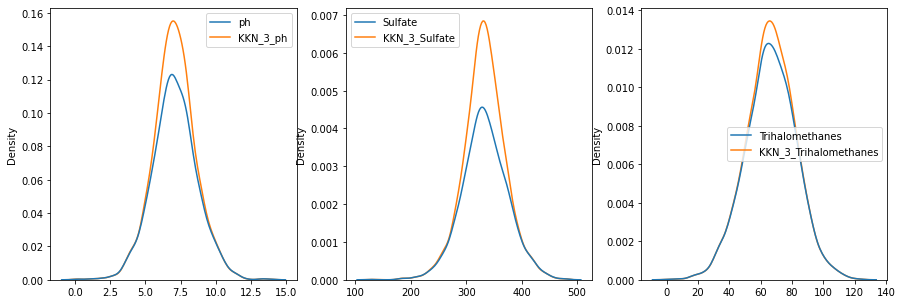

In [11]:
new_data = data_to_impute.join(imputed_data)

n_rows = 1
n_cols = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5))
for i in range(len(data_to_impute.columns)):
  sns.kdeplot(data=new_data.iloc[:, [i, i+3]], ax=axes[i])

In [12]:
data = data.join(imputed_data)

data = data.drop(['ph', 'Sulfate', 'Trihalomethanes'], axis=1)

# 2. Нормализация числовых признаков

Проанализируем схожесть распределений числовых признаков с нормальным распределением

In [13]:
def diagnostic_plots(column):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
  plt.axes(axes[0])
  plt.title(column)
  sns.histplot(data[column], ax=axes[0])
  stats.probplot(data[column], dist='norm', plot=axes[1])

[None, None, None, None, None, None, None, None, None]

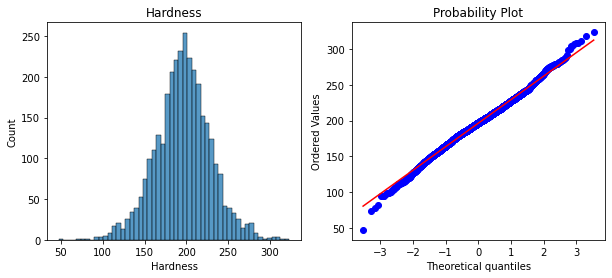

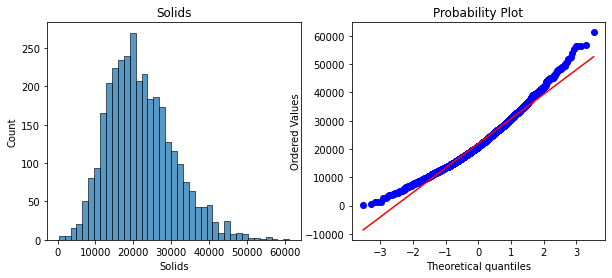

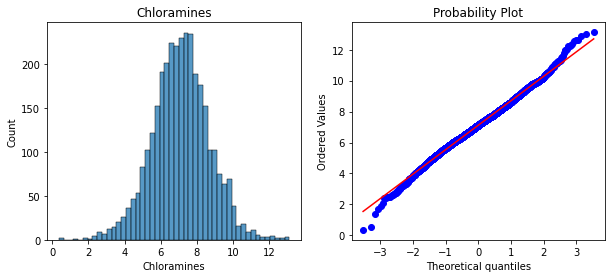

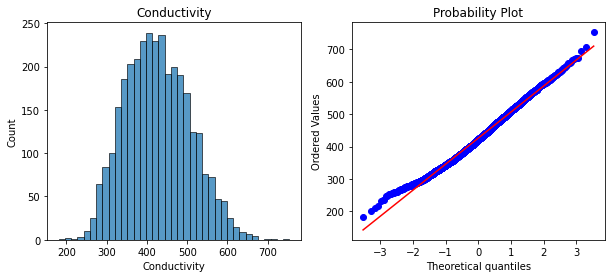

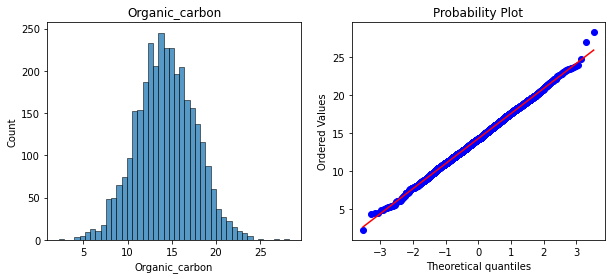

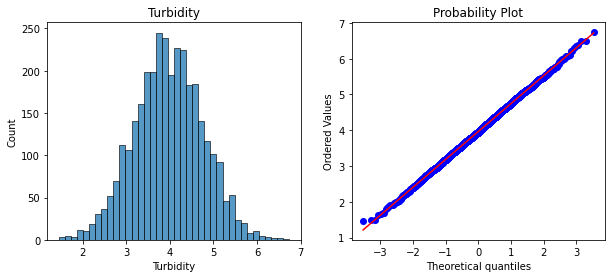

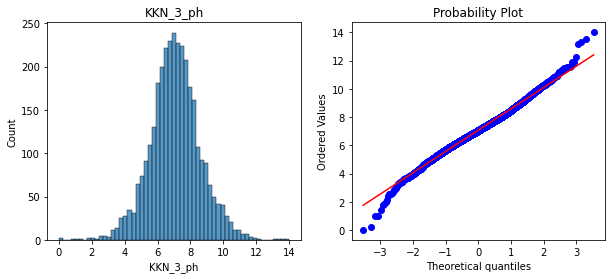

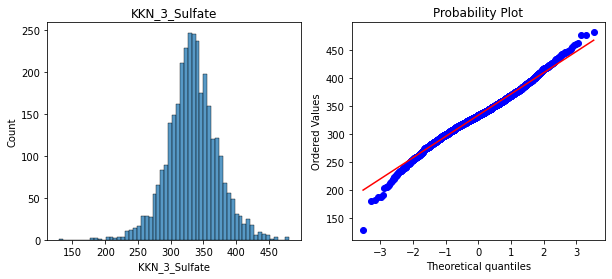

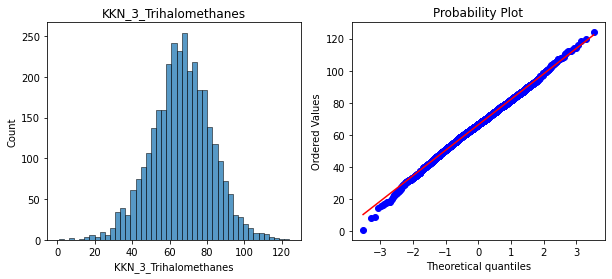

In [14]:
[diagnostic_plots(column) for column in data]  

Признак `Solids` обладает распределением, наиболее отличным от нормального. Именно его и следует нормализовать.

Оптимальное значение λ = 0.5239560378014094


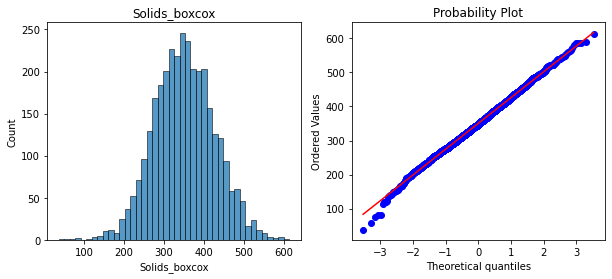

In [15]:
data['Solids_boxcox'], param = stats.boxcox(data['Solids']) 
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots('Solids_boxcox')

# 3. Кодирование категориальных признаков

In [16]:
data = pd.read_csv('/content/drive/MyDrive/ММО/games.csv')

In [17]:
data['winner'].value_counts()

white    10001
black     9107
draw       950
Name: winner, dtype: int64

In [18]:
ohe = OneHotEncoder()
ohe_matrix = ohe.fit_transform(data[['winner']])
ohe_matrix

<20058x3 sparse matrix of type '<class 'numpy.float64'>'
	with 20058 stored elements in Compressed Sparse Row format>

In [19]:
data['winner'][:10]

0    white
1    black
2    white
3    white
4    white
5     draw
6    white
7    black
8    black
9    white
Name: winner, dtype: object

In [20]:
ohe_matrix.todense()[:10]

matrix([[0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])

In [21]:
pd.get_dummies(data[['winner']])[:10]

,winner_black,winner_draw,winner_white
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
5,0,1,0
6,0,0,1
7,1,0,0
8,1,0,0
9,0,0,1
